In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils

import process_data
import config
import network
import net_local

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [135]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

In [ ]:
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [84]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [128]:
selected_indice = [1, 2, 5, 6, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 27, 28, 31, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 53, 56, 58, 60, 62, 63, 65, 66, 67, 68, 70, 72, 73, 75, 77, 81, 84, 85, 88, 89, 90, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 111, 113, 117, 120, 121, 122, 125, 126, 130, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 152, 155, 156, 162, 164, 165, 167, 171, 174, 177, 179, 181, 183, 184, 185, 187, 190, 193, 195, 196, 197, 199, 202, 210, 213, 215, 223, 225, 226, 227, 229, 231, 232, 236, 242, 247, 249, 251, 253, 254, 265, 270, 273, 279, 280, 284]

In [129]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]
n_100307_sub = n_all_100307[:,selected_indice]

big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(135, 3)


In [130]:

net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub, device)
state_dict = torch.load("/Users/weiwenhua/UG_Project_Remote/9g-m/02-local/model_96d2e24e-c6c4-4477-83d0-5513ad6ae2d8.pt", map_location=torch.device('cpu'))
net.load_state_dict(state_dict)
net.eval()

# net = net_local.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_6g_02.pt"))
# net.eval()

# net = net_local.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# net.load_state_dict(torch.load("/Users/weiwenhua/UG_Project_Local/model_98b31eb9-83ba-478a-af73-9e5b2e9b25f3.pt"))
# net.eval()


# net = net_local.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# net.load_state_dict(torch.load("/Users/weiwenhua/UG_Project_Remote/5g-m/notebook-03-retrain/model_cdbd8581-1418-4c32-b2e1-cd8759e369f2.pt"))
# net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=135, out_features=5, bias=True)
  )
)

In [131]:
with torch.no_grad():
    X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

## Parameter Maps -Subsampling

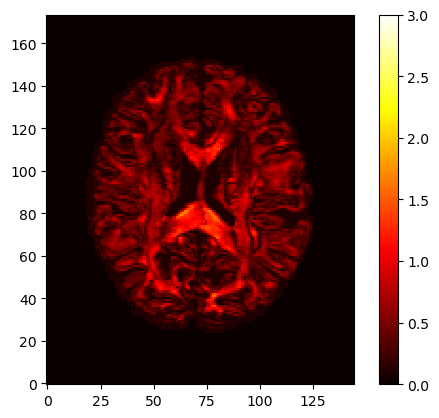

In [132]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

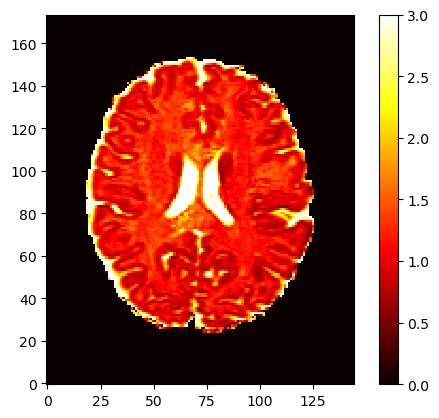

In [316]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

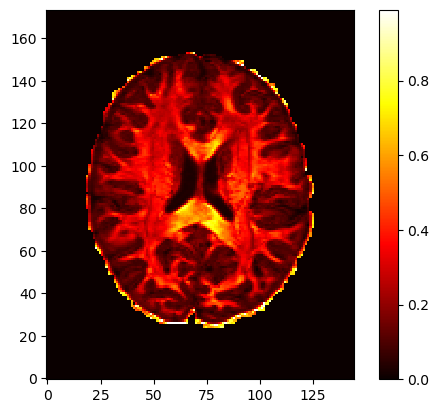

In [317]:
volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

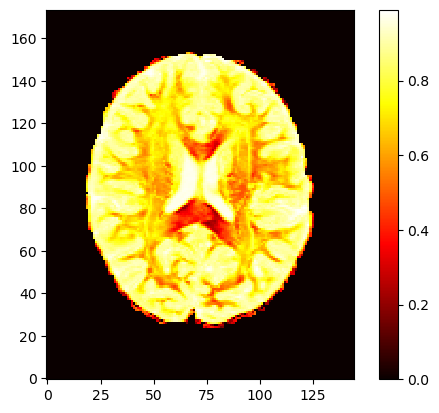

In [318]:
volume_1_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred, (145, 174, 145))
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


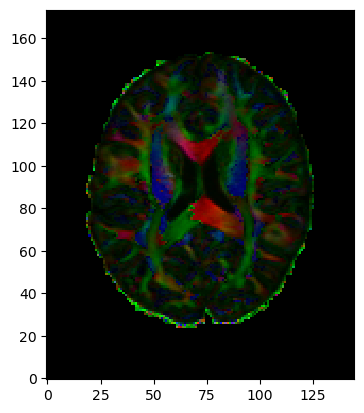

In [319]:
mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307 = np.copy(mask_for_mu)
mu_cart_100307_pred_cp = np.copy(mu_cart_100307_pred.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307[index[0], index[1]] = mu_cart_100307_pred_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped = resume_mu_100307.reshape((145, 174, 145, 3))

volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
volume_0_100307_slice = volume_0_100307_pred_3d[:,:,70]
r = np.repeat(volume_0_100307_slice[:, :, np.newaxis], 3, axis=2)
dir = mu_100307_reshaped[:,:,70,:] * r

plt.imshow(np.rot90(dir, 3), origin='lower', interpolation='nearest')

## Golden STD

In [63]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [64]:
net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307, device)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [65]:
with torch.no_grad():
    X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [14]:
lambda_par_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_gstd, (145, 174, 145))
lambda_iso_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred_gstd, (145, 174, 145))
volume_0_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred_gstd, (145, 174, 145))
volume_1_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred_gstd, (145, 174, 145))

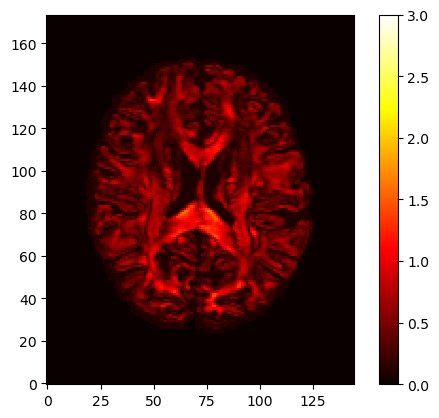

In [18]:
im = plt.imshow(lambda_par_100307_pred_gstd_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

In [15]:
# mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
# no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307_gstd = np.copy(mask_for_mu)
mu_cart_100307_pred_gstd_cp = np.copy(mu_cart_100307_pred_gstd.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307_gstd[index[0], index[1]] = mu_cart_100307_pred_gstd_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped_gstd = resume_mu_100307_gstd.reshape((145, 174, 145, 3))

volume_0_100307_gstd_slice = volume_0_100307_pred_gstd_3d[:,:,70]
r_gstd = np.repeat(volume_0_100307_gstd_slice[:, :, np.newaxis], 3, axis=2)
dir_map_gstd = mu_100307_reshaped_gstd[:,:,70,:] * r_gstd

plt.imshow(np.rot90(dir_map_gstd, 3), origin='lower', interpolation='nearest')

NameError: name 'mask_for_mu' is not defined

# Dmipy NLLS

In [4]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

def get_fitted_parameters(scan_slice, mask_slice, bvals, gradient_directions):
    scheme = get_acquisition_scheme(bvals, gradient_directions)
    
    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    BAS_mod = MultiCompartmentModel(models=[stick, ball])
    
    BAS_fit = BAS_mod.fit(scheme, scan_slice, mask_slice)
    
    return BAS_fit, BAS_fit.fitted_parameters

In [17]:
BAS_fit_100307_slice, fitted_parameters_100307_slice = get_fitted_parameters(scan_100307[:, :, 70, :], mask_100307[:,:,70], bvals_all_100307*1e6, n_all_100307.T)

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.3161017894744873 seconds
Fitting of 10903 voxels complete in 338.63102197647095 seconds.
Average of 0.031058518020404564 seconds per voxel.


In [20]:
fitted_parameters_100307_slice.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])

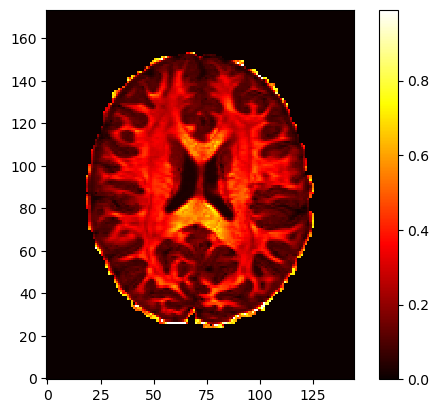

In [23]:
im = plt.imshow(fitted_parameters_100307_slice.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

In [31]:
# [ 60  61  64  65  67  68  69  73  74  77  78  80  84  85  89  94  95 104
#  111 129 144 145 149 164 165 192 193 195 196 221 222 223 224 225 226 227
#  250 251 252 253 254 255 256 279 280 281 282 283 284 285 308 309 310 311
#  312 313 314 337 344 374 404 433 434 463 464 492 493 522 550 577 578 579
#  580 607 608 609 610 628 632 633 634 651 653 654 676 678 679 697 698 700
#  701 702 716 717 718 719 729 730]
print(fitted_parameters_100307_slice.get("partial_volume_0").shape)
print(volume_0_100307_pred_gstd_3d[:,:,70].shape)

(145, 174)
(145, 174)


In [51]:
gstd_stick_frac = np.where(volume_0_100307_pred_gstd_3d[:,:,70]>= 0.5)
gstd_stick_frac_indice = list(zip(gstd_stick_frac[0],gstd_stick_frac[1]))
# print(gstd_stick_frac_indice)
print(len(gstd_stick_frac_indice))

print(np.where(volume_0_100307_pred_gstd == 0.))

703
(array([], dtype=int64), array([], dtype=int64))


In [39]:
nlls_stick_frac = np.where(fitted_parameters_100307_slice.get("partial_volume_0")>= 0.5)
nlls_stick_frac_indice = list(zip(nlls_stick_frac[0],nlls_stick_frac[1]))
print(nlls_stick_frac_indice)
print(len(nlls_stick_frac_indice))

[(19, 95), (20, 70), (20, 71), (23, 61), (23, 62), (23, 63), (24, 60), (24, 61), (25, 59), (25, 60), (28, 52), (28, 53), (29, 49), (29, 50), (30, 49), (31, 132), (31, 133), (31, 134), (32, 45), (32, 46), (32, 132), (32, 133), (32, 134), (32, 135), (33, 43), (33, 44), (33, 135), (34, 41), (34, 136), (35, 40), (35, 41), (36, 39), (37, 39), (38, 37), (38, 38), (38, 140), (38, 141), (39, 140), (40, 34), (40, 35), (40, 36), (40, 141), (40, 142), (41, 33), (41, 34), (41, 142), (42, 32), (42, 34), (42, 116), (43, 33), (43, 34), (43, 116), (43, 144), (44, 32), (44, 33), (44, 144), (45, 31), (46, 30), (47, 29), (47, 30), (47, 31), (47, 146), (48, 29), (48, 30), (49, 28), (49, 29), (49, 30), (49, 133), (49, 148), (50, 28), (50, 29), (50, 133), (50, 148), (50, 149), (51, 28), (51, 29), (51, 133), (51, 149), (51, 150), (52, 27), (52, 28), (52, 149), (52, 150), (53, 44), (53, 45), (53, 46), (53, 150), (54, 27), (54, 44), (54, 45), (54, 150), (54, 151), (55, 26), (55, 151), (56, 26), (56, 151), (57,

In [47]:
lambda_par_100307_pred_gstd_3d[62,27,70]

0.10000000149011612

In [55]:
np.where(volume_0_100307_pred_gstd < 0.1)[0]

array([   157,    183,    184, ..., 739941, 739969, 739970])

# Parameters Eval

In [17]:
mse = torch.nn.MSELoss(reduction='mean')

In [133]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0024)
tensor(0.0068)
tensor(0.0001)
tensor(0.0001)


In [49]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [134]:
output = cos(mu_cart_100307_pred_gstd, mu_cart_100307_pred)
print(torch.mean(output))
print(torch.std(output))

tensor(0.9491)
tensor(0.1430)


In [ ]:
# notebook-quarter, notebook-02-retrain, notebook-03-retrain, remote-02, 04-local,05-local,07,08
sub_5g = [0.8761, 0.8513, 0.9017, 0.8988, 0.8759, 0.8318,0.8657,0.8746,0.8778,0.8652,0.8762,0.8652,0.9008]

# notebook-01, notebook-02, notebook-03
sub_6g = [0.8602, 0.9204, 0.8670,0.8665,0.8696,0.9259,0.8444,0.8221,0.8731,0.8982,0.8137,0.8710]
sub_7g = [0.8208]
# _,_,_,_,local
sub_8g = [0.9449, 0.8768, 0.9164, 0.2583,0.9013,0.9134]
# sub_9g = [0.0023, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]
sub_10g = [0.9027, 0.9243, 0.8781, 0.9292, 0.7964, 0.8905]
# sub_11g = [0.0017, 0.0040,0.0058,0.0044,0.0032,0.0021, 0.0044]
# sub_13g = [0.0049,0.0034,0.0038,0.0035,0.0040,0.0019,0.0018]
# sub_15g = [0.0032,0.0032,0.0012,0.0027]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('Mean of cosine similarity of gradient directions')

ax.set_xticks(x_values)

In [ ]:
# 5-03 remote-02
sub_5g = [0.2933, 0.3460, 0.2284,0.2286, 0.2743,0.3568,0.3120,0.2897,0.2916,0.3120,0.2785,0.3120,0.2070]

sub_6g = [0.3199, 0.1922, 0.3128,0.2951,0.3068,0.1768,0.3548,0.4011,0.3037,0.2583,0.3721,0.3080]

sub_7g = [0.4062]
sub_8g = [0.1489,0.3152, 0.1998,0.2583,0.2381]
# sub_9g = [0.0023, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]
sub_10g = [0.2791, 0.2286, 0.3314, 0.1871, 0.4466, 0.3026]
# sub_11g = [0.0017, 0.0040,0.0058,0.0044,0.0032,0.0021, 0.0044]
# sub_13g = [0.0049,0.0034,0.0038,0.0035,0.0040,0.0019,0.0018]
# sub_15g = [0.0032,0.0032,0.0012,0.0027]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('Standard Dev of cosine similarity of gradient directions')

ax.set_xticks(x_values)

(array([ 18019.,   5780.,   5594.,   6113.,   7445.,   9558.,  13765.,
         22556.,  48581., 602734.]),
 array([-9.99998927e-01, -7.99998999e-01, -5.99999130e-01, -3.99999201e-01,
        -1.99999303e-01,  5.96046448e-07,  2.00000495e-01,  4.00000393e-01,
         6.00000322e-01,  8.00000191e-01,  1.00000012e+00]),
 <BarContainer object of 10 artists>)

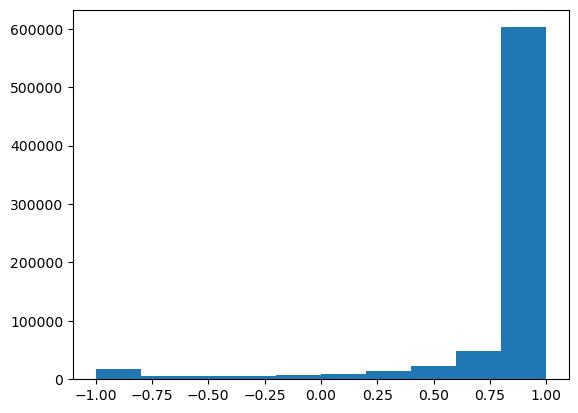

In [118]:
plt.hist(output.detach().numpy())

# Average

In [ ]:
tensor(0.0069)
tensor(0.0119)
tensor(0.0003)
tensor(0.0003)

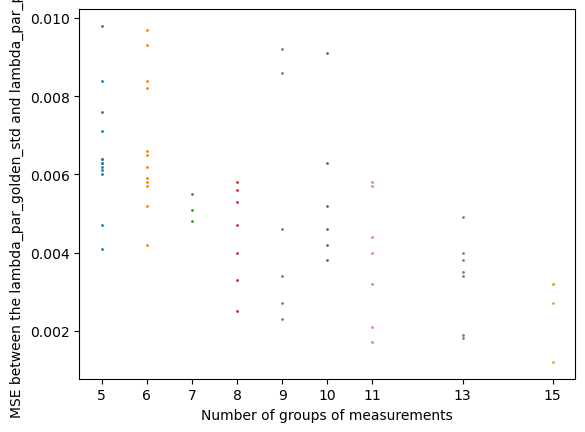

In [296]:
sub_5g = [0.0060,0.0063,0.0041, 0.0047, 0.0061,0.0084,0.0071,0.0098,0.0076,0.0064,0.0063,0.0064,0.0062]
sub_6g = [0.0059,0.0052,0.0084,0.0093,0.0058,0.0065,0.0062,0.0057,0.0066,0.0042,0.0097,0.0082]
sub_7g = [0.0048, 0.0051, 0.0055]

sub_8g = [0.0040, 0.0033, 0.0058, 0.0025, 0.0053, 0.0056, 0.0047]

sub_9g = [0.0023, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]
sub_10g = [0.0052, 0.0046, 0.0042, 0.0063,0.0091, 0.0038]
sub_11g = [0.0017, 0.0040,0.0058,0.0044,0.0032,0.0021, 0.0057]
sub_13g = [0.0049,0.0034,0.0038,0.0035,0.0040,0.0019,0.0018]
sub_15g = [0.0032,0.0032,0.0012,0.0027]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=1)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_par_golden_std and lambda_par_pred')

ax.set_xticks(x_values)
# ax.set_ylim([0, 0.035])

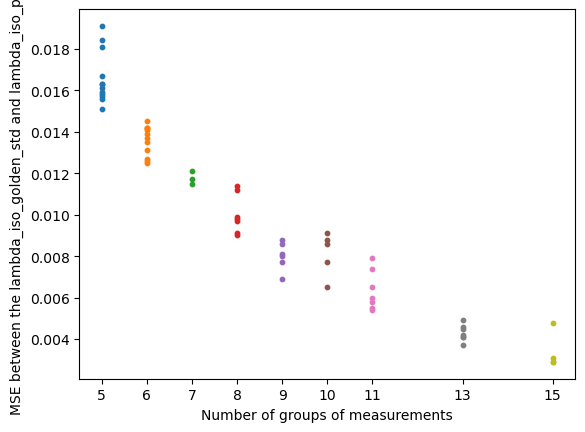

In [423]:
# sub_5g = [0.0184, 0.0157,0.0151,0.0167, 0.0159, 0.0161,0.0158, 0.0181,0.0333,0.0163,0.0156,0.0163,0.0191]
sub_5g = [0.0184, 0.0157,0.0151,0.0167, 0.0159, 0.0161,0.0158, 0.0181,0.0163,0.0156,0.0163,0.0191]

sub_6g = [0.0142,0.0135,0.0126,0.0141,0.0137,0.0145,0.0127,0.0131,0.0139,0.0125,0.0142,0.0142]
# sub_6g = [0.0142,0.0135,0.0126,0.0141,0.0137,0.0127,0.0131,0.0139]

sub_7g = [0.0117, 0.0115, 0.0121]
sub_8g = [0.0097, 0.0114, 0.0098, 0.0090, 0.0112, 0.0099,0.0091]
sub_9g = [0.0086, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]
# sub_10g = [0.0077, 0.0086, 0.0065, 0.0091, 0.0088, 0.0251]
sub_10g = [0.0077, 0.0086, 0.0065, 0.0091, 0.0088]
sub_11g = [0.0058, 0.0055,0.0060,0.0079,0.0074,0.0054, 0.0065]
sub_13g = [0.0042, 0.0041, 0.0046,0.0049,0.0045,0.0041,0.0037]
sub_15g = [0.0029,0.0048,0.0031,0.0029]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_iso_golden_std and lambda_iso_pred')

ax.set_xticks(x_values)



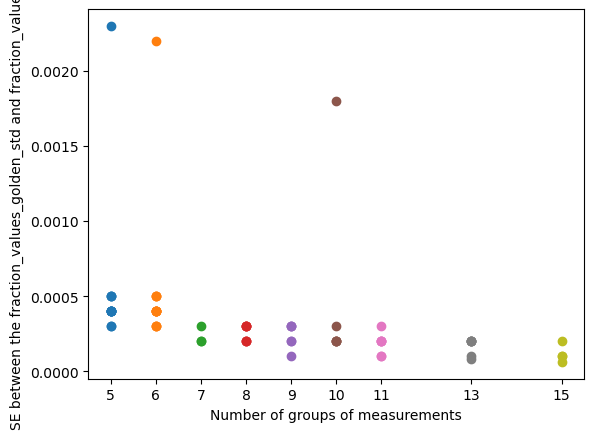

In [297]:
sub_5g = [0.0004,0.0004,0.0003,0.0004,0.0003,0.0005,0.0004, 0.0005,0.0023,0.0004,0.0004,0.0004,0.0005]

sub_6g = [0.0004,0.0004,0.0005,0.0004,0.0005,0.0003,0.0022,0.0004,0.0003,0.0004,0.0003,0.0005,0.0004]

sub_7g = [0.0003, 0.0002, 0.0002]
sub_8g = [0.0002, 0.0002, 0.0003, 0.0002, 0.0003, 0.0003,0.0003]
sub_9g = [0.0001, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]
sub_10g = [0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0018]
sub_11g = [0.0001, 0.0002,0.0003,0.0002,0.0002,0.0001, 0.0002]
sub_13g = [0.0002, 0.0002, 0.0002,0.0002,0.0002,8.3640e-05,0.0001]
sub_15g = [0.0001,0.0001,6.2200e-05,0.0002]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the fraction_values_golden_std and fraction_values_pred')

ax.set_xticks(x_values)


# SSIM and MSE for parameter maps

In [24]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [25]:
def get_ssim_mse(pmap1, pmap2):
    ssim_val = ssim(pmap1, pmap2)
    mse_val = mean_squared_error(pmap1, pmap2)
    return ssim_val, mse_val

In [298]:
print(get_ssim_mse(lambda_par_100307_pred_gstd_3d, lambda_par_100307_pred_3d))
print(get_ssim_mse(lambda_iso_100307_pred_gstd_3d, lambda_iso_100307_pred_3d))
print(get_ssim_mse(volume_0_100307_pred_gstd_3d, volume_0_100307_pred_3d))
print(get_ssim_mse(volume_1_100307_pred_gstd_3d, volume_1_100307_pred_3d))

ssim_val_dir_map = ssim(dir_map_gstd, dir, channel_axis=2)
mse_val_dir_map = mean_squared_error(dir_map_gstd, dir)
print(ssim_val_dir_map, mse_val_dir_map)

(0.9780538461244751, 0.0013198563751653724)
(0.9914598075745417, 0.002924493593561416)
(0.9965917388874479, 6.511533528377209e-05)
(0.9967916738483005, 6.511533535388194e-05)
0.897330702587965 0.0026324812768512853


* SSIM and MSE for Lambda_par maps

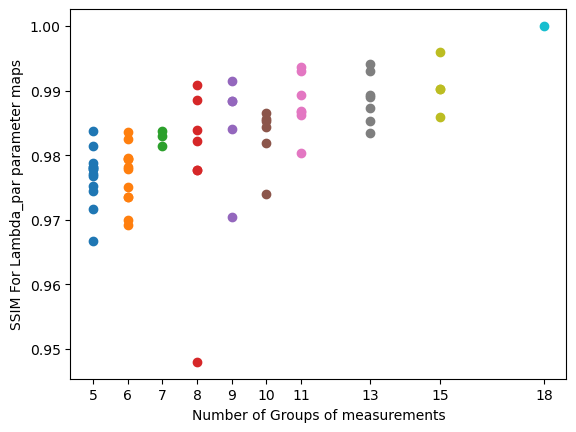

In [236]:
sub_5g = [0.9788538832736747, 0.9770700448430096, 0.9836789113491305,
          0.9813888201679715,0.9781848803703839,0.9716136957118762,
          0.9744034484156524,0.9667232849890809,0.9751985010058605,
          0.9777984249926718,0.9767318097803884,0.9777984249926718,
          0.9782058538004906]

sub_6g = [0.9793431844675979, 0.9825478350199264,0.973525156065646,
          0.9700386902768913,0.979471370850552,0.9780538461244751,
          0.9778524394454129,0.9795824177179208,0.9781797956695624, 
          0.9835712924053569,0.9691882981779969,0.9735050753718644]

sub_7g = [0.9830184766670942, 0.9836695575902945, 0.9814134332993826]
sub_8g = [0.977708749991149, 0.98855634844329, 0.9776401493239765, 0.99090469753936, 0.9480144373626562, 0.9821881906310987,0.9839071432036022]
sub_9g = [0.9915366861790111, 0.9840687373251713,0.9883799184488312, 0.9883739656809384, 0.9704518254313225]
sub_10g = [0.9843837872316462, 0.985525418579196, 0.98523124780312, 0.9819389813056897, 0.9740276848332764, 0.9865761791173795]
sub_11g = [0.9936738668199634, 0.9868621432868203, 0.9803850431003096, 0.9866942652038659, 0.989311332710161, 0.9930438386914109, 0.98616525150096]
sub_13g = [0.9834123291426734, 0.9892579368323642, 0.9852512676981304, 0.9890045843413818, 0.9873096548566452, 0.9941598034751709, 0.9930453115352653]
sub_15g = [0.9859329063018878, 0.9902492250217612, 0.9959438956137685, 0.990257738711818]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Lambda_par parameter maps')
ax.set_xticks(x_values)



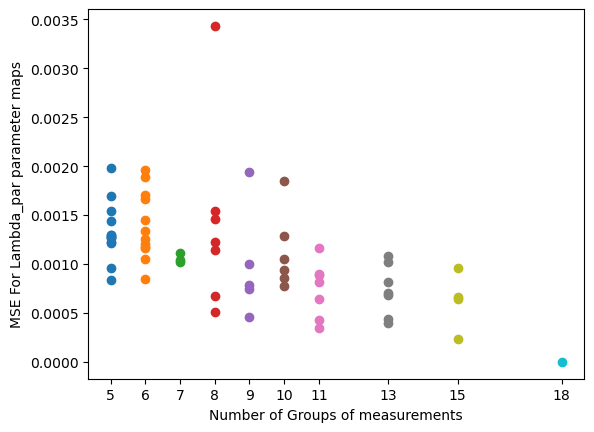

In [237]:
sub_5g = [0.0012191791126153976, 0.0012749682855075078, 0.0008379829845869107,
          0.0009561238452540751,0.001229508709217711,0.001692052201285773,
          0.0014437124820961906,0.0019854954410749113,0.001540929604403217,
          0.0012993143523092336,0.0012718681242914352,0.0012993143523092336,
          0.0012643212805133123]

sub_6g = [0.0012026091223116264, 0.0010524107882335023,0.0017081661124738394,
          0.0018854295026000912,0.0011741754488483673,0.0013198563751653724,
          0.0012557800008918137,0.001158896220806534,0.0013375862690892903,
          0.0008505505747081956,0.00196259115309345,0.0016607657192696378]

sub_7g = [0.001036552400296914, 0.001023592036099843, 0.0011152046722088596]
sub_8g = [0.0015428680219389936, 0.0006754114172982294, 0.0014558777758749589, 0.0005113713337595285, 0.0034322200355861934, 0.0011399223571870452,0.001229508709217711]
sub_9g = [0.00046230438031050496, 0.0009980150907870039,0.0007853647712574188, 0.0007478811357140815, 0.0019367481322465476]
sub_10g = [0.0010541604899302023, 0.0009354799949922836,  0.0008572047519565675, 0.0012837960405257657, 0.0018474201520307682, 0.0007757139540335439]
sub_11g = [0.000342323773253722, 0.000819301775223355, 0.0011651972323278976, 0.0008972381758997132, 0.0006465604789900008, 0.00042338486708403626, 0.0008907981705759358]
sub_13g = [0.001082687912095597, 0.0006867487033802363, 0.0010238830413833635, 0.0007074985244084551, 0.0008135312596682492, 0.0003940008507071108, 0.00043527430599917113]
sub_15g = [0.0009635745345478282, 0.000646753915319165, 0.00023801184880616356, 0.0006657276555355847]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Lambda_par parameter maps')
ax.set_xticks(x_values)


* SSIM and MSE for Lambda_iso maps

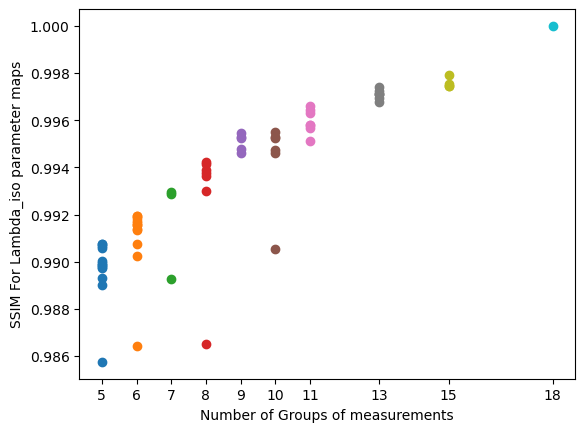

In [238]:
sub_5g = [0.9899388303102081, 0.989843935335544, 0.9906524027563643,
          0.9897356725165078,0.9900081887990194,0.9898642633525252,
          0.9897564510172765,0.9889949549707432,0.9857479526525271,
          0.9907598886346883,0.9905912118145993,0.9907598886346883,
          0.9893024625735951]

sub_6g = [0.9902425004694484, 0.991550862434621,0.9913894176650931,
          0.991335216410275,0.9915558941547133,0.9914598075745417,
          0.9916268162421663,0.9918572417571556,0.9919477709030067,
          0.9919249208482213,0.9907413741098825,0.9917287617411504]

sub_7g = [0.9929426612627144, 0.9928732835984075, 0.9892541526785961]
sub_8g = [0.9865009654150169, 0.9929875514253627, 0.9936515172276236, 0.9938877121235974, 0.9937493717611898, 0.9941501838938159,0.9942084741531576]
sub_9g = [0.9954633431636167, 0.9946015324935225, 0.9952821834256229, 0.9952325592830672, 0.9947703233009024]
sub_10g = [0.9952888139255747, 0.9952280846602605, 0.9954932794005285, 
           0.9947367662762368, 0.9946208957699114, 0.9905542060003031]
sub_11g = [0.9964310819729749, 0.9963234487749101, 0.9956704273069564, 0.9951398292643242, 0.995806671999177, 0.9965842605088573, 0.9957775542507356]
sub_13g = [0.9969497075906014,0.997098246656391, 0.9967887218046171, 0.9970974926314625, 0.9971320158367466, 0.9972290087034256, 0.9973974108984194]
sub_15g = [0.9974356464498618, 0.997448101278163, 0.997921500914057, 0.9975565263569428]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Lambda_iso parameter maps')
ax.set_xticks(x_values)


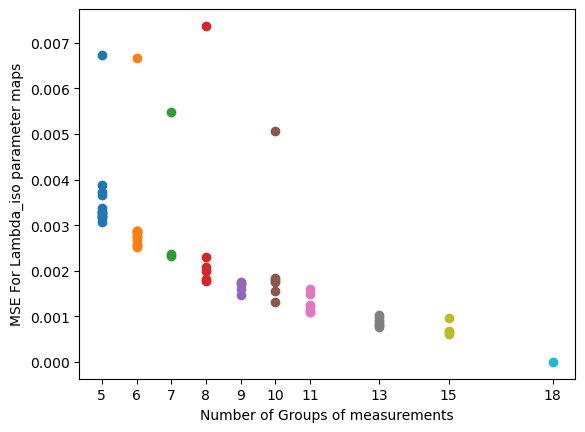

In [239]:
sub_5g = [0.0037213794013724343, 0.0031846177002894374, 0.003058816237293465,
          0.0033813090550797982,0.0032141559695743316,0.0032667692522847383,
          0.003198492543300651,0.0036546290524895214,0.006734204195183989,
         0.0032966554428999644,0.003164103779897006,0.0032966554428999644,
          0.003871914595027879]

sub_6g = [0.0028654086390666887, 0.0027314108707665423,0.0025531498421260367,
          0.0028589643435418316,0.0027686555108011276,0.002924493593561416,
          0.002570249546967626, 0.002652622096160838,0.00280481189463364,
          0.002527942297205551,0.002877017950959223,0.0028650260669576847]

sub_7g = [0.0023656906258047597, 0.0023341988009446557, 0.005492777527715979]
sub_8g = [0.007370921164912833, 0.002298740632148711, 0.002079055807592994, 0.0018294006703314845, 0.0017680098640614264, 0.0019936136709182675]
sub_9g = [0.0017466535575937753, 0.001731578240499696, 0.0017075882149832026,0.0014727933495720408, 0.0015907794079519353]

sub_10g = [0.001561544272333294, 0.0017464541212541943, 0.0013187330678983632, 0.0018427388143417126, 0.0017897198970012868, 0.00507492432088525]
sub_11g = [0.0011395739986478199, 0.001105913566987152, 0.001225138724782639, 0.001598196993988727, 0.0014988206639575954, 0.0010859694018533188, 0.0012416811372352962]
sub_13g = [0.000876430063480257, 0.0008197611376329894, 0.0010324948374323246, 0.0009913742184068405, 0.0009104269032768368, 0.000819490660109063, 0.0007586437047484404]
sub_15g = [0.0006855365465011624, 0.000965865038185378, 0.0006179210089879208, 0.0006520861018961497]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Lambda_iso parameter maps')
ax.set_xticks(x_values)


* SSIM and MSE for stick_fraction maps

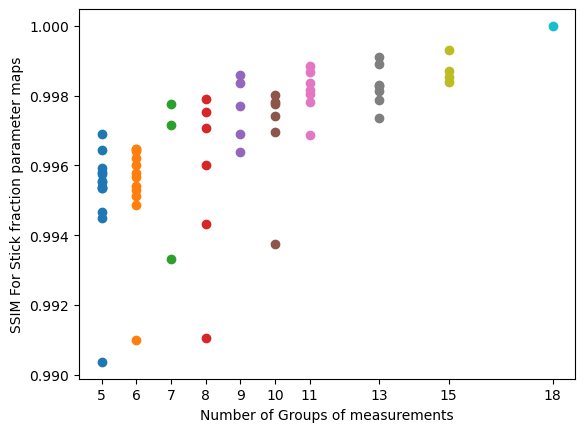

In [240]:
sub_5g = [0.995756272555713, 0.9953935572776939, 0.9968925462114261,
          0.9959315802603543,0.9964330576650021, 0.9944997080534718,
          0.9955260456753388,0.9946619272476354,0.9903638919982026,
          0.9953547429323799,0.9958198521972802,0.9953547429323799,
          0.9955565903119841]

sub_6g = [0.9954025046085587, 0.9964169100209529, 0.9952801172260022,
          0.9951098952569578,0.9960006014048709,0.9965917388874479,
          0.9957890816105989,0.9964786413092453,0.9962029269143152,
          0.9964789394322265,0.9948530573830819,0.9956649033255947]

sub_7g = [0.9971444290677269, 0.997774922268137, 0.9933075697084556]
sub_8g = [0.9910482604151682,0.9975339904402777, 0.9960216945046345, 0.9979077529355034, 0.9943086495518791, 0.9970825703840309]
sub_9g = [0.998590481191039, 0.9969118624115217, 0.9983768739529159, 0.9977049416903311, 0.9963838743834653]
sub_10g = [0.9977479323744463, 0.9978286288885686, 0.9974215374811871, 0.99802240681437, 0.9969509213178067, 0.9937468682734651]
sub_11g = [0.9988441075327278, 0.997804879885554, 0.9968706525051317, 0.9983671348620409, 0.9981654353339054, 0.9986891536579993, 0.9980415777820909]
sub_13g = [0.9973654748238636, 0.9981220990753779, 0.9983062334251274, 0.9982782699265627, 0.9978863482054229, 0.9991057302589033, 0.9988944380860967]
sub_15g = [0.9985264335870586, 0.998402468156555, 0.9993073743577967, 0.9987041707875421]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Stick fraction parameter maps')
ax.set_xticks(x_values)


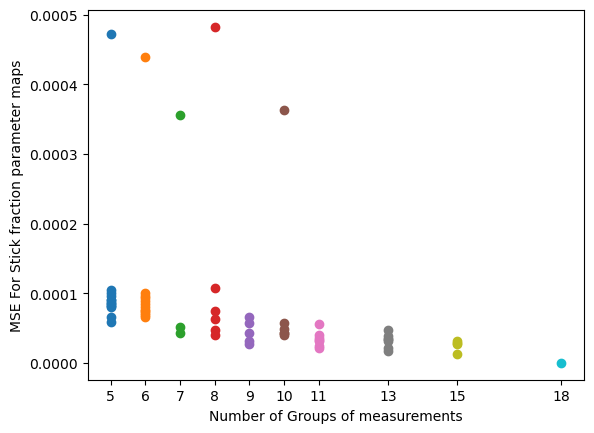

In [241]:
sub_5g = [8.58752601553163e-05, 8.658088045546068e-05,5.873896700541076e-05,
          8.125128876707918e-05,6.649856771129071e-05, 0.00010543988828019267,
          8.353988324295096e-05, 0.00010063357015340926,0.0004722015476498559,
          9.005230823966381e-05,8.025262503799466e-05,9.005230823966381e-05,
          9.665371463553564e-05]

sub_6g = [8.867981960490828e-05, 7.190942322512636e-05,9.324116026261013e-05,
          9.54897048908001e-05,7.586103206357083e-05, 6.511533528377209e-05,
          7.985383275592795e-05, 6.557949454427251e-05,7.45575050722377e-05,
          6.812690601430278e-05, 0.00010001392321155261,8.499026118631074e-05]

sub_7g = [5.228665809509343e-05, 4.259578124822216e-05, 0.0003566334706733673]
sub_8g = [0.0004825227263713608, 4.686233600642654e-05,7.411586890237598e-05, 4.010337713102054e-05, 0.00010825980999984138, 6.326099530261599e-05]
sub_9g = [2.776975234773326e-05, 5.780381521054784e-05, 3.1066685087672e-05, 4.274249320682423e-05, 6.589885093913448e-05]

sub_10g = [4.316099016657439e-05, 4.259706239209034e-05, 4.888039271762763e-05, 4.071136055227541e-05, 5.7723948883055574e-05, 0.0003637572960232955]
sub_11g = [2.183805800865263e-05, 3.971804585618461e-05, 5.5226659339894005e-05, 3.084999861246646e-05, 3.3550626631021705e-05, 2.4933112929731393e-05, 3.626071712685962e-05]
sub_13g = [4.774445345753439e-05, 3.4308436684075874e-05, 3.403398347625411e-05, 3.156225745711012e-05, 3.8787306948945e-05, 1.692181862086043e-05, 2.091950103100162e-05]
sub_15g = [3.1289927853903544e-05, 2.8398962013827765e-05, 1.2584175737511735e-05, 2.738806771143417e-05]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Stick fraction parameter maps')
ax.set_xticks(x_values)



In [ ]:
# local-retrain3, remote-02, local-04
sub_5g = [0.9959954874537199, 0.9956807396641689, 0.997091392511164,
          0.9959315802603543, 0.9966530750534813,0.9948004695560152,
          0.995794209868524,0.9949657685287087,0.9906063924256985,
          0.9956224130382064,0.9960645872806592,0.9956224130382064,
          0.9958618842502053]

sub_6g = [0.9957102775437053, 0.9966524394747054, 0.9955571396266826,
          0.995389170436867,0.9962262937547138,0.9967916738483005,
          0.9960784061527248,0.9967014902639311,0.9964017848586935,
          0.9966905839450344,0.9951544236721599, 0.9959185444048808]

# sub_7g = [5.228665809509343e-05, 4.259578124822216e-05, 0.0003566334706733673]
sub_8g = [0.9980368832174833, 0.9946535489596188, 0.9972758796954183]
# sub_9g = [2.776975234773326e-05, 5.780381521054784e-05, 3.1066685087672e-05, 4.274249320682423e-05, 6.589885093913448e-05]
sub_10g = [0.9978836129080162, 0.997953463051525, 0.9975669887267448, 0.998156908473042, 0.9971375903789658, 0.9937296293699704]
# sub_11g = [2.183805800865263e-05, 3.971804585618461e-05, 5.5226659339894005e-05, 3.084999861246646e-05, 3.3550626631021705e-05, 2.4933112929731393e-05, 3.626071712685962e-05]
# sub_13g = [4.774445345753439e-05, 3.4308436684075874e-05, 3.403398347625411e-05, 3.156225745711012e-05, 3.8787306948945e-05, 1.692181862086043e-05, 2.091950103100162e-05]
# sub_15g = [3.1289927853903544e-05, 2.8398962013827765e-05, 1.2584175737511735e-05, 2.738806771143417e-05]
# sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Ball fraction parameter maps')
ax.set_xticks(x_values)


In [ ]:
sub_5g = [8.587526014585326e-05, 8.658088055201196e-05, 5.873896717619437e-05,
          8.125128876707918e-05, 6.649856755885094e-05, 0.00010543988689230407,
          8.353988309500497e-05,0.0001006335701607773,0.0004722015499061502,
          9.00523081954782e-05,8.025262482192874e-05,9.00523081954782e-05,9.665371326500791e-05]

sub_6g = [8.8679819263384e-05 , 7.190942244508151e-05, 9.324116024748367e-05,
          9.548970484998549e-05,7.58610318721858e-05,6.511533535388194e-05,
          7.985383274273322e-05, 6.55794942685765e-05,7.455750524973946e-05,
          6.812690623207245e-05,0.00010001392328527295,8.499026049190432e-05]
# sub_7g = [5.228665809509343e-05, 4.259578124822216e-05, 0.0003566334706733673]
sub_8g = [4.010337710139564e-05, 0.00010825980982184201, 6.326099530670457e-05]
# sub_9g = [2.776975234773326e-05, 5.780381521054784e-05, 3.1066685087672e-05, 4.274249320682423e-05, 6.589885093913448e-05]
sub_10g = [4.3160990203461144e-05, 4.259706245716625e-05, 4.888039241342551e-05, 4.888039241342551e-05, 4.071136022324586e-05, 5.772394882379239e-05, 0.00036375729602622836]
# sub_11g = [2.183805800865263e-05, 3.971804585618461e-05, 5.5226659339894005e-05, 3.084999861246646e-05, 3.3550626631021705e-05, 2.4933112929731393e-05, 3.626071712685962e-05]
# sub_13g = [4.774445345753439e-05, 3.4308436684075874e-05, 3.403398347625411e-05, 3.156225745711012e-05, 3.8787306948945e-05, 1.692181862086043e-05, 2.091950103100162e-05]
# sub_15g = [3.1289927853903544e-05, 2.8398962013827765e-05, 1.2584175737511735e-05, 2.738806771143417e-05]
# sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Ball fraction parameter maps')
ax.set_xticks(x_values)

* SSIM and MSE for angle dirction maps

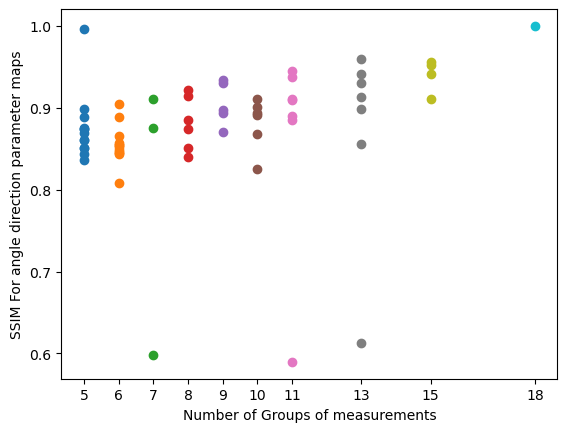

In [242]:
sub_5g = [0.8610871463333428, 0.8439523862934349, 0.89824657014346,
          0.9961836772334786, 0.8745574276434954, 0.8357031416933752,
          0.8754237804954319,0.8692872733843128,0.8612614391852196,
          0.8513178366405704,0.8745134032568199,0.8513178366405704,
          0.8891358064876022]

sub_6g = [0.8540804646899511, 0.9041206185669314,0.8455722230918806,
          0.8438725167498017,0.8546940365947929,0.897330702587965,
          0.8566680891396071,0.8452983949648446,0.8515809642982076,
          0.8886195834600277,0.8076797309294603,0.8658003058198771]

sub_7g = [0.8747973393367316, 0.9111473368314199, 0.5987216106705319]
sub_8g = [0.873565541007722, 0.9147578348921672, 0.851067472658397, 0.9216913157627844, 0.8396329964653403, 0.8855080839259207]
sub_9g = [0.9304429306142891, 0.8701097240515328, 0.9343306343228542,0.8968269696213284,0.8935498537579761]

sub_10g = [0.8912391684489762, 0.9012485457829095, 0.8684988722239791, 0.9111682227230865, 0.8255229683985236, 0.8936369794643803]
sub_11g = [0.9375096041024601, 0.885376194111954, 0.5896994539555892, 0.9099917909187015, 0.9104970829659201, 0.9452144443727436, 0.8902316893129368]
sub_13g = [0.8562511792036996, 0.8990500274483756, 0.9306270228808508, 0.9132387559589984, 0.6123796315011288, 0.9597451981695192, 0.941843444477716]
sub_15g = [0.9409474919312046, 0.9107949932149673, 0.9562030887248917,0.9523129512461296]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For angle direction parameter maps')
ax.set_xticks(x_values)


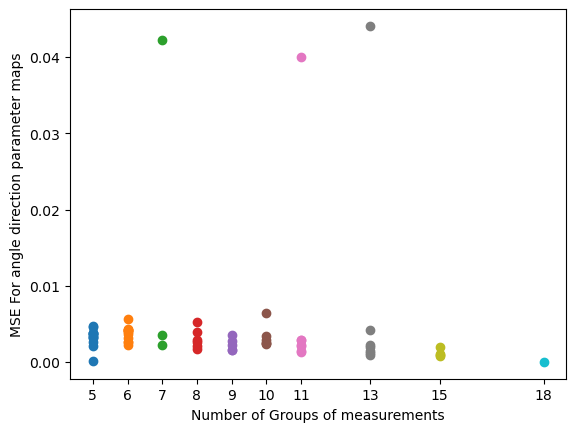

In [299]:
sub_5g = [0.0035557805290997078,  0.004651171490671066, 0.0026198079469420747,
          8.125128895930136e-05,0.0032186772357910105, 0.004601015376296784, 
          0.0036838672158926934, 0.0032525214045464623, 0.0038257358260544087,
          0.0037541810404212966,0.0031386550135541207,0.0037541810404212966, 
          0.0020754438295234436]

sub_6g = [0.0036627866928544473, 0.0022085461836690644, 0.004205730536611581, 
          0.004258492919569796, 0.003971109487645513,  0.0026324812768512853,
          0.0031651548711875, 0.0042192762595252824, 0.004125027265494771,
          0.002561795610371272, 0.00563541278801633, 0.004113910337918736]

sub_7g = [0.003490942895590238, 0.0022202393078372836, 0.042209352621237976]
sub_8g = [0.002841221147201351, 0.002096287277636201, 0.0038768486782062464, 0.0017316489797416265, 0.005292161921811758,  0.0025645635614432835]
sub_9g = [0.0016253811334667973, 0.0035096288864162415, 0.0015951197946020626, 0.0022552130581891153,0.0027325108251645192]

sub_10g = [0.0028529001395297465, 0.0024923834590187027, 0.003458815255670017,  0.0024716289319084966, 0.00638821935194213, 0.002349890997833796]
sub_11g = [0.0013748133720775367,  0.0029200378535124043, 0.04002114438967472, 0.0020301378564268092, 0.002173126466294961, 0.0012388192405793494, 0.0029363048611570804]
sub_13g = [0.00416823447426363, 0.0021686090108145963, 0.0013955068260538069, 0.001949367483680303, 0.044088633872010355, 0.0008926219500614515, 0.0011095881111700572]
sub_15g = [0.001019844497138992, 0.0019440547291586028, 0.0008049514512604328, 0.0008880948576550622]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For angle direction parameter maps')
ax.set_xticks(x_values)



In [246]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

bvals = np.loadtxt(config.data_folder2 + '/100206/bvals')*1e6
bvecs = np.loadtxt(config.data_folder2 + '/100206/bvecs').T

scheme = get_acquisition_scheme(bvals, bvecs)
# print(scheme.bvalues)
print(scheme.print_acquisition_info)
print(scheme.b0_threshold)
print(scheme.min_b_shell_distance)

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |5               |3                        |10.6       |43.1      |N/A  
1           |90        |998             |56                       |10.6       |43.1      |N/A  
2           |90        |1998            |79                       |10.6       |43.1      |N/A  
3           |90        |2996            |97                       |10.6       |43.1      |N/A  
None
10000000.0
50000000.0


In [252]:
scheme.qvalues

array([ 1789.12383582, 25302.03193384, 35737.72063048, 43860.90997737,
       25238.69758686, 43787.86927727, 35827.17689216, 25175.20390744,
       35692.90842398, 43824.40484414, 25302.03193384, 35648.03988528,
       43787.86927727, 25365.20814188, 35737.72063048, 43787.86927727,
        1789.12383582, 25238.69758686, 35782.47671643, 43897.38475289,
       43860.90997737, 25238.69758686, 35827.17689216, 25238.69758686,
       35692.90842398, 43714.70653731, 25365.20814188, 35782.47671643,
       43860.90997737, 25238.69758686, 35737.72063048, 43751.30320052,
        1789.12383582, 43860.90997737, 25238.69758686, 35782.47671643,
       25175.20390744, 35692.90842398, 43751.30320052, 25238.69758686,
       43714.70653731, 35737.72063048, 43860.90997737, 25238.69758686,
       35827.17689216, 25302.03193384, 35692.90842398, 43787.86927727,
        1789.12383582, 25365.20814188, 35827.17689216, 43787.86927727,
       43824.40484414, 25365.20814188, 35648.03988528, 25365.20814188,
      